## Import Statements
### The libraries used are `pandas`, `pathlib`, `imblearn`, and `sklearn`. 

In [4]:
import pandas as pd
from pathlib import Path
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Import the data and create a dataframe
1. Use `pandas` and `pathlib` to read the `BankChurnersPrimary.csv` CSV from the `Resources` folder.
2. Sample the dataset to review the data.

In [5]:
starter_df = pd.read_csv(Path("c://users/ajcth/documents/github/bank_churn_model/Resources/BankChurnersPrimary.csv"))
starter_df.sample(5)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
5467,769330908,Existing Customer,49,F,4,High School,Married,Less than $40K,Blue,43,...,2574.0,1555,1019.0,0.583,4134,62,0.550,0.604,0.000526,0.99947
2501,788783133,Existing Customer,58,F,0,Post-Graduate,Married,Less than $40K,Blue,39,...,6679.0,1207,5472.0,0.538,1649,29,0.381,0.181,0.000305,0.99969
2061,720171033,Existing Customer,45,M,4,Unknown,Married,$60K - $80K,Blue,36,...,11498.0,1577,9921.0,0.756,4014,70,0.489,0.137,0.000038,0.99996
5432,779635533,Existing Customer,38,F,3,Graduate,Single,Unknown,Blue,21,...,2348.0,1028,1320.0,0.469,5125,71,0.578,0.438,0.000096,0.99990
6515,718279008,Attrited Customer,44,M,3,High School,Single,$60K - $80K,Silver,36,...,25276.0,0,25276.0,0.849,2282,38,0.583,0.000,0.994300,0.00570


## Drop any Unknown or NaN values

In [6]:
starter_df = starter_df[starter_df != 'Unknown'].dropna()

## Remove any columns that won't be used.
Naive Bayes columns can't be used (it's calculated from features and target).

CLIENTNUM is irrelevant.

In [7]:
starter_df.drop(columns=[
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 
'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
'CLIENTNUM'
], 
inplace= True)

## Evaluate the Education column for use as a feature
The Education values are ranked from uneducated to doctorate, and is a gradient rather than ambiguous classifications. 

The ranks will be converted to numericals and specified as datatype `int`.
1. Uneducated = 0
2. Highschool = 1
3. College = 2
4. Graduate = 3
5. Post-Grad = 4
6. Doctorate = 5

In [8]:
starter_df = starter_df.replace({'Education_Level' : {
'Uneducated': 0, 
'High School': 1, 
'College' : 2, 
'Graduate' :  3, 
'Post-Graduate' : 4, 
'Doctorate' : 5
}})
starter_df.Education_Level = starter_df.Education_Level.astype(int)

## Evaluate the Card Type column for use as a feature
The Card Type values are ranked from blue to platinum, and is a gradient rather than ambiguous classifications. The ranks will be converted to numericals and specified as datatype `int`.
1. Blue = 0
2. Silver = 1
3. Gold = 2
4. Platinum = 3


In [9]:
starter_df = starter_df.replace({'Card_Category' : {
'Blue': 0, 
'Silver': 1, 
'Gold' : 2, 
'Platinum' : 3
}})
starter_df.Card_Category = starter_df.Card_Category.astype(int)

## Evaluate the Gender column for use as a feature
Gender is a binary classification, so we don't need to OneHotEncode.
The values will be converted to numericals and specified as datatype `int`.
1. Male = 0
2. Female = 1 


In [10]:
starter_df = starter_df.replace({'Gender' : {
'M': 0, 
'F': 1
}})
starter_df.Gender = starter_df.Gender.astype(int)

## Evaluate the Attrition_Flag column for use as the target
Attrition_Flag is a binary classification, so we don't need to OneHotEncode.
The values will be converted to numericals and specified as datatype `int`.
1. Attrited Customer = 0
2. Existing Customer = 1 

In [11]:
starter_df = starter_df.replace({'Attrition_Flag' : {
'Attrited Customer': 0, 
'Existing Customer': 1
}})
starter_df.Attrition_Flag = starter_df.Attrition_Flag.astype(int)

## Perform feature creation on the Dependents and Marital_Status features to create the Marital_Dependent_Ratio feature
The values will be converted to numericals and specified as datatype `int`.
Divorced and Single will be combined, as they are both single income sources.
1. Divorced = 1
2. Single = 1 
3. Married = 2

The formula for Marital_Dependent_Ratio is as follows:

( Marital_Status / (Dependents + 1) / 2 )

The original Marital_Status and Dependents columns will be dropped in place of the Marital_Dependent_Ratio column.

In [12]:
starter_df = starter_df.replace({'Marital_Status' : {
'Divorced': 1, 
'Single': 1, 
'Married' : 2
}})
starter_df.Marital_Status = starter_df.Marital_Status.astype(int)
starter_df['Marital_Dependent_Ratio'] = ((starter_df['Marital_Status'] / (starter_df['Dependent_count'] + 1)) / 2).round(2)
starter_df.drop(columns=['Marital_Status', 'Dependent_count'], inplace=True)


## Perform feature creation on the Avg_Open_To_Buy and Credit_Limit features to create the Avg_Trans_Value feature. Its a simple ratio.
The original Avg_Open_To_Buy and Credit_Limit columns will be dropped in place of the Credit_Usage column.

In [13]:
starter_df['Credit_Usage'] = (starter_df['Avg_Open_To_Buy'] / starter_df['Credit_Limit']).round(2)
starter_df.drop(columns=['Avg_Open_To_Buy', 'Credit_Limit'], inplace=True)

## Perform feature creation on the Total_Trans_Amt and Total_Trans_Ct features to create the Avg_Trans_Value feature. Its a simple ratio.
The original Total_Trans_Amt and Total_Trans_Ct columns will be dropped in place of the Avg_Trans_Value column.

In [14]:
starter_df['Avg_Trans_Value'] = (starter_df['Total_Trans_Amt'] / starter_df['Total_Trans_Ct']).round(2)
starter_df.drop(columns=['Total_Trans_Amt', 'Total_Trans_Ct'], inplace=True)

## Perform feature creation on the Tenure(month) and Age features to create the Tenure_By_Age feature. Its a simple ratio.

The original Tenure(month) and Age columns will be dropped in place of the Tenure_By_Age column.

In [15]:
#Do feature creation to make a ratio between age and tenure
starter_df['Tenure_By_Age'] = (starter_df['Months_on_book'] / starter_df['Customer_Age']).round(2)
starter_df.drop(columns=['Months_on_book', 'Customer_Age'], inplace=True)

## Evaluate the Income column for use as the target
 The Income values are ranked in blocks, and is a gradient rather than ambiguous classifications. The ranks will be converted to numericals and specified as datatype `int`.

In [16]:
starter_df = starter_df.replace({'Income_Category' : {
'Less than $40K': 0, 
'$40K - $60K': 1, 
'$80K - $120K' : 2, 
'$60K - $80K' : 3, 
'$120K +' : 4
}})
starter_df.Income_Category = starter_df.Income_Category.astype(int)

## Review the new features

In [17]:
starter_df.dtypes

Attrition_Flag                int32
Gender                        int32
Education_Level               int32
Income_Category               int32
Card_Category                 int32
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Total_Revolving_Bal           int64
Total_Amt_Chng_Q4_Q1        float64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
Marital_Dependent_Ratio     float64
Credit_Usage                float64
Avg_Trans_Value             float64
Tenure_By_Age               float64
dtype: object

In [18]:
starter_df.sample(5)

,Attrition_Flag,Gender,Education_Level,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Marital_Dependent_Ratio,Credit_Usage,Avg_Trans_Value,Tenure_By_Age
6759,1,1,0,0,0,5,4,2,1240,0.906,0.950,0.559,0.50,0.44,56.36,0.88
5357,1,1,0,0,0,3,2,4,578,0.931,0.717,0.109,0.33,0.89,57.08,0.92
3555,0,0,1,1,0,2,3,4,512,0.176,0.130,0.035,0.17,0.97,55.88,0.80
1447,1,0,3,1,0,4,3,3,1792,0.904,0.769,0.317,0.33,0.68,41.61,0.61
1150,1,1,4,0,0,5,3,2,2005,0.659,0.806,0.341,0.25,0.66,34.48,0.90


<AxesSubplot:>

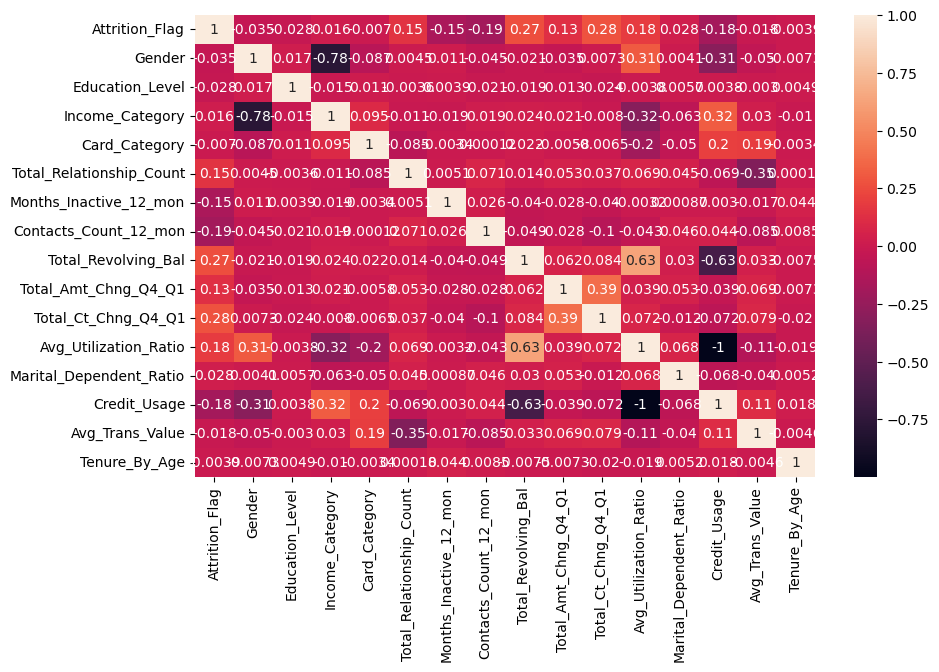

In [19]:
cor = starter_df.corr()

plt.figure(figsize = (10,6))
sns.heatmap(cor, annot = True)

## Define our features(X) and our target(y)

In [16]:
y = starter_df['Attrition_Flag']
X = starter_df.drop(columns=['Attrition_Flag'])

## Split features and target in to training and testing sets

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Using StandardScaler, scale all numerical/float values that don't represent ambiguous categories
### StandardScaler will be used within ColumnTransformer. This allows for the scaling of specified columns within our X_train and X_test set.
It's critical that the StandardScaler is only fit to our X_train. Both X_train and X_test will be transformed, but the StandardScaler will only be fit to X_train.This prevents the model from 'cheating'.

In [18]:
scaler = StandardScaler()

col_tran= ColumnTransformer([
('Total_Revolving_Bal_Scaled', scaler, ['Total_Revolving_Bal']),
('Education_Scaled', scaler, ['Education_Level']),
('Income_Scaled', scaler, ['Income_Category']),
('Card_Type_Scaled', scaler, ['Card_Category']),
('Months_Inactive_12_mon_scaled', scaler, ['Months_Inactive_12_mon']),
('Credit_Usage_Scaled', scaler, ['Credit_Usage']),
('Avg_Trans_Value_Scaled', scaler, ['Avg_Trans_Value']),
('Tenure_By_Age_Scaled', scaler, ['Tenure_By_Age']),
('Avg_Util_Ratio_Scaled', scaler, ['Avg_Utilization_Ratio']),
('Total_Relationship_Count_Scaled', scaler, ['Total_Relationship_Count']),
('Contacts_Count_12_mon_scaled', scaler, ['Contacts_Count_12_mon']),
('Total_Amt_Chng_Q4_Q1_scaled', scaler, ['Total_Amt_Chng_Q4_Q1']),
('Total_Ct_Chng_Q4_Q1_scaled', scaler, ['Total_Ct_Chng_Q4_Q1']),
('Marital_Dependent_Ratio_Scaled', scaler, ['Marital_Dependent_Ratio'])
])


X_train = col_tran.fit_transform(X_train)
X_test = col_tran.transform(X_test)

## Use SMOTE to add synthetic data and balance our target/feature value count
This will only be done on the training data.

In [19]:
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

## Create an instance of the GradientBoostingClassifier model
Hyperparameter tuning was mostly unhelpful; only two hyperparameters have been changed from default values.
1. n_estimators = 500
2. random_state= 2

In [20]:
gbc_model = GradientBoostingClassifier(
n_estimators=500,                 #default = 100    range = 1-inf
random_state= 2,                  #default = None   range = 1-inf
subsample= 1,                     #default = 1      range = 0.-1
min_samples_split = 2,            #default = 2      range = 2-inf
max_depth=3,                      #default = 3      range = 1-inf
min_impurity_decrease=0,          #default = 0      range = 0 - inf
min_samples_leaf = 1,             #default = 1      range = 1 - inf
min_weight_fraction_leaf = 0,     #default = 0      range =0 - 0.5
max_leaf_nodes = None,            #default = None   range = 2-inf
learning_rate = 0.1               #default=0.1      range 0.0-inf
)

## Fit the model on the training data

In [21]:
gbc_model.fit(X_train, y_train)

GradientBoostingClassifier(min_impurity_decrease=0, min_weight_fraction_leaf=0,
                           n_estimators=500, random_state=2, subsample=1)

## Make predictions on the test data

In [22]:
gbc_test_predictions = gbc_model.predict(X_test)

## Evaluate the model's performance

In [23]:
accuracy = accuracy_score(y_test, gbc_test_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 92.55%


## Generate a confusion matrix

In [24]:
gbc_test_matrix = confusion_matrix(y_test, gbc_test_predictions)
print(gbc_test_matrix)

[[ 200   77]
 [  55 1439]]


## Generate a classification report

In [25]:
gbc_testing_report = classification_report(y_test, gbc_test_predictions)
print(gbc_testing_report)

              precision    recall  f1-score   support

           0       0.78      0.72      0.75       277
           1       0.95      0.96      0.96      1494

    accuracy                           0.93      1771
   macro avg       0.87      0.84      0.85      1771
weighted avg       0.92      0.93      0.92      1771



## Generate an imbalanced classification report

In [26]:
imb__gbc_testing_report = classification_report_imbalanced(y_test, gbc_test_predictions)
print(imb__gbc_testing_report)

                   pre       rec       spe        f1       geo       iba       sup

          0       0.78      0.72      0.96      0.75      0.83      0.68       277
          1       0.95      0.96      0.72      0.96      0.83      0.71      1494

avg / total       0.92      0.93      0.76      0.92      0.83      0.71      1771

